# Финальный проект
Вариант 2

## Задание 1. A/B–тестирование

1.1 **Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 **Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

*groups_add.csv* - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

*active_studs.csv* - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

*checks.csv* - файл с информацией об оплатах пользователей в дни проведения эксперимента.

1.3 **Вопросы**

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?

Являются ли эти различия статистически значимыми?

Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

1.4 **Требования к ответу**

- При выполнении тестового задания необходимо использовать язык программирования Python.
- В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными.
- Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

Загрузим библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, probplot
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

In [2]:
# !chcp 1251

In [3]:
groups = pd.read_csv('./data/groups.csv', sep= ';')
active_studs = pd.read_csv('./data/active_studs.csv')
checks = pd.read_csv('./data/checks.csv', sep= ';')
group_add = pd.read_csv('./data/group_add.csv')

Разделители в таблицах разные.

Посмотрим на данные

In [4]:
def df_info(df):
    '''Функция получает Датафрейм и выводит первые строки и общую информацию'''
    print(df.head())
    print(df.shape)
    print()

In [5]:
dfs = pd.Series([groups, active_studs, checks, group_add])
dfs.apply(df_info);

     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A
(74484, 2)

   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369
(8341, 1)

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0
(541, 2)

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B
(92, 2)



Видим, что поле ID в таблицах имеет разные имена. Приведём имя поля к одному имени.
(Будем надеяться, что это один и тот же ID, из задания следует именно это.)

In [6]:
def id_rename(df):
    '''Функция проверяет первый столбец датафрейма и переименовывает его если его имя 'student_id' '''
    if df.columns[0] == 'student_id':
        df.rename(columns={'student_id': 'id'}, inplace = True)
dfs.apply(id_rename);

Проверим уникальность значений ID в таблицах перед объединением.

In [7]:
def show_duplicates(df):
    '''Функция выводит количество повторяющихся строчек в поле 'id'
    '''
    print(f'Количество повторяющихся ID - {df.id.duplicated().sum()}')
dfs.apply(show_duplicates);

Количество повторяющихся ID - 0
Количество повторяющихся ID - 0
Количество повторяющихся ID - 0
Количество повторяющихся ID - 0


ID везде уникальны!

У нас есть две таблицы groups, внесём в них допоплнительный признак и соединим.

In [8]:
groups['added'] = 0
group_add['added'] = 1
full_groups = pd.concat([groups, group_add])
groups.shape[0] + group_add.shape[0], full_groups.shape[0]

(74576, 74576)

In [9]:
full_groups.id.duplicated().sum()

0

In [10]:
full_groups.grp.value_counts()[0] / full_groups.shape[0]

0.8029795108345849

Посмотрим все ли активные и оплатившие пользователи вошли в общую таблицу.

In [11]:
active_studs.id.isin(full_groups.id).all(), checks.id.isin(full_groups.id).all()

(True, True)

Добавим идентификатор активного пользователя и соединим таблицы.

In [12]:
active_studs['active'] = 1
checks['paid'] = 1
full_data = full_groups.merge(active_studs, how = 'left', on = 'id')
full_data = full_data.merge(checks, how = 'left', on = 'id')
full_data.fillna(0, inplace = True)

In [13]:
(full_data.active == full_data.paid).all()

False

In [14]:
full_data.active.value_counts()[1], full_data.paid.value_counts()[1]

(8341, 541)

Далеко не все активные пользователи сделели оплату. Посмотрим на отношение Активных и Оплативших.

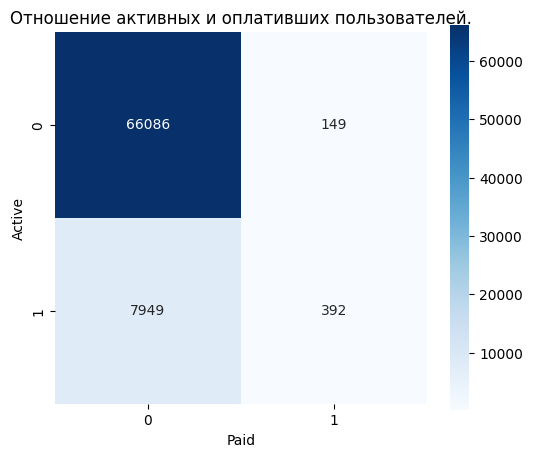

In [15]:
cm = confusion_matrix(full_data.active, full_data.paid)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', square=True, fmt='g')
plt.title('Отношение активных и оплативших пользователей.')
plt.xlabel('Paid')
plt.ylabel('Active')
plt.show()

In [16]:
paid_no_active = full_data.loc[(full_data.active == 0) & (full_data.paid == 1)]
paid_no_active.grp.value_counts()

B    120
A     29
Name: grp, dtype: int64

Вряд ли решение об оплате неактивных пользователей продиктовано новым предложением. Исключим такие наблюдения из тестовой группы.

In [17]:
full_data.drop(paid_no_active.loc[paid_no_active.grp == 'B'].index, axis = 0, inplace = True)

In [18]:
full_data.shape

(74456, 6)

#### CR - конверсия в покупку

In [19]:
cr = full_data.loc[full_data.active == 1] \
    .groupby('grp', as_index=False) \
    .agg({'active':'count'})

cr['paid'] = full_data.loc[full_data.paid == 1] \
                    .groupby('grp').agg({'active':'count'}) \
                    .active.to_list()

cr['cr'] = round((cr.paid / cr.active) * 100, 2)

cr

,grp,active,paid,cr
0,A,1538,107,6.96
1,B,6803,314,4.62


Конверсия снизилась.

Помотрим связаны ли оплатвшие пользователи с тем в какой группе они оказались, для этого посчитаем Хи-квадрат Пирсона для Конверсии.\
Этот тест проверяет H0 - категории (оплатил \ не оплатил) Не зависят от групп (A, B)\
Соотетственно Альтернативная H1 - частота плательшиков разная между группами.

In [20]:
cross_t = pd.crosstab(full_data.loc[full_data.active == 1].grp, full_data.paid)
chi2, p, dof, expected = chi2_contingency(cross_t)

print(f"chi2 statistic:     {chi2:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:")
print(expected)

chi2 statistic:     0.48481
p-value:            0.48625
degrees of freedom: 1
expected frequencies:
[[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]]


P-value показывает, что не достаточно оснований для отклонения H0, об отсутсвии значимых различий в распределениях.

####  ARPU

In [21]:
# ARPU
arpu = full_data.loc[full_data.active == 1] \
    .groupby('grp', as_index=False).agg({'id':'count', 'rev':'sum'}) \
    .rename(columns={'id':'num_active'}).round()

arpu['arpu'] = round(arpu.rev / arpu.num_active,1)

arpu

,grp,num_active,rev,arpu
0,A,1538,72820.0,47.3
1,B,6803,394974.0,58.1


In [22]:
full_data.loc[full_data.paid == 1]

,id,grp,added,active,rev,paid
1,1627,A,0,1.0,990.0,1.0
220,100300,B,0,1.0,990.0,1.0
320,108270,B,0,1.0,290.0,1.0
406,114366,A,0,0.0,690.0,1.0
2041,212994,A,0,0.0,690.0,1.0
...,...,...,...,...,...,...
74365,5645737,B,0,1.0,1900.0,1.0
74381,5651566,B,0,1.0,1900.0,1.0
74402,5662322,B,0,1.0,1900.0,1.0
74452,5681918,B,0,1.0,1900.0,1.0


ARPU увеличилось

####  ARPPU

In [23]:
# ARPPU
arppu = full_data.loc[full_data.paid == 1] \
    .groupby('grp', as_index=False).agg({'id':'count', 'rev':'sum'}) \
    .rename(columns={'id':'num_active'}).round()

arppu['arppu'] = round(arppu.rev / arppu.num_active,1)
arppu

,grp,num_active,rev,arppu
0,A,107,92096.0,860.7
1,B,314,394974.0,1257.9


ARPPU увеличилось в 1.5 раза

Проверим нормальность распределения revenu по активным и платящим пользователям.\
Сравним квантили с нормальным распределением. 

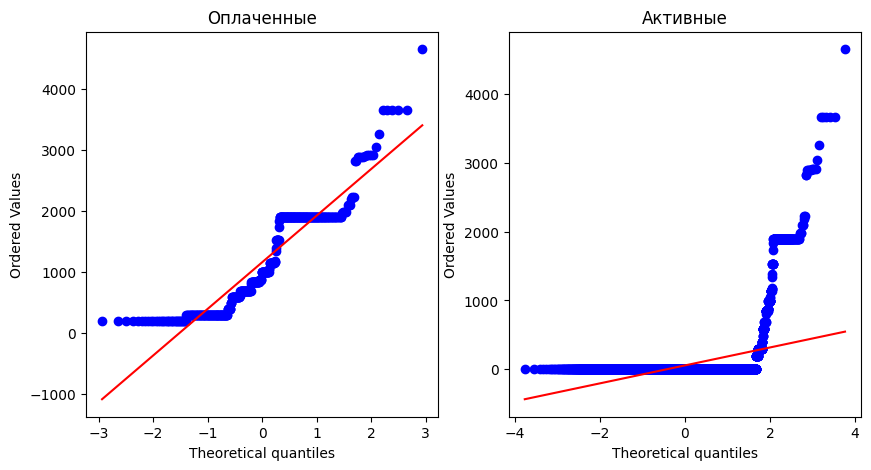

In [24]:
# Разделим на группы.
data_group1 = full_data.loc[full_data.paid == 1].rev
data_group2 = full_data.loc[full_data.active == 1].rev

# Выводим QQ-графики для каждой группы.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

probplot(data_group1, plot=axes[0])
axes[0].set_title('Оплаченные')

probplot(data_group2, plot=axes[1])
axes[1].set_title('Активные')
plt.show()

Распределения нельзя назвать нормальными.

Проведём Бутстреп ARPU и ARPPU.\
Поскольку распределения не нормальные.


Посмотрим на расспределения разности средних по случайным выборкам из распределений по группам.\
Будем оценивать входит ли нулевая разница в 95% доверительный интервал.

Дополнительно проведём t-тест для независимых выборок.\
Для обоих тестов:\
H0 - выборки не имеют значимых различий,\
H1 - выборки значимо отличаются.

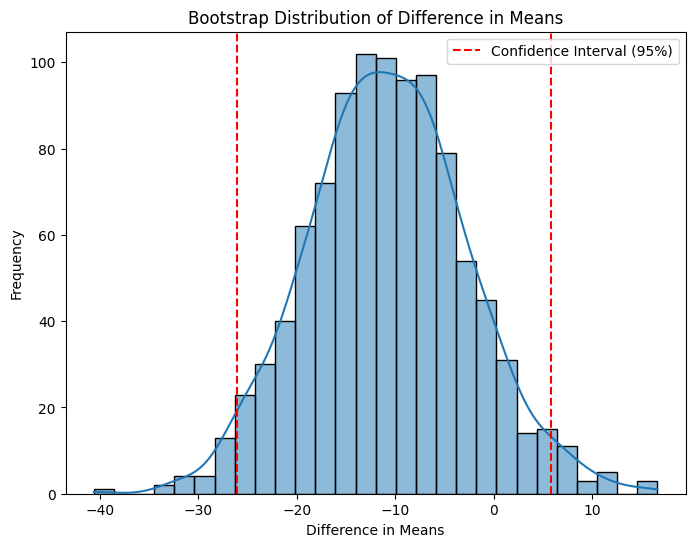

{'ci': array([-26.08677993,   5.78849627]), 'p_value': 0.22048133326988378}

In [25]:
def get_bootstrap(df):
    # Split the dataframe into two groups
    group1 = df[df.grp == 'A'].rev
    group2 = df[df.grp == 'B'].rev
    bootstrap_differences = []
    for _ in range(1000):  # number of bootstrap samples
        sample_group1 = resample(group1)
        sample_group2 = resample(group2)
        difference = np.mean(sample_group1) - np.mean(sample_group2)
        bootstrap_differences.append(difference)

    confidence_interval = np.percentile(bootstrap_differences, [2.5, 97.5])
    t_statistic, p_value = ttest_ind(group1, group2)

    plt.figure(figsize=(8, 6))
    sns.histplot(bootstrap_differences, kde=True)
    plt.axvline(confidence_interval[0], color='red', linestyle='--', label='Confidence Interval (95%)')
    plt.axvline(confidence_interval[1], color='red', linestyle='--')
    plt.title('Bootstrap Distribution of Difference in Means')
    plt.xlabel('Difference in Means')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    return {"ci": confidence_interval,
            "p_value": p_value}

bootstrap_results = get_bootstrap(full_data.loc[full_data.active == 1])
bootstrap_results

По бутстрепу:\
Нулевая разница входит в 95% доверительный интервал.\
разница стремиться к нулю, распределения совпадают.
По тесту Студента:\
P-value большое, различия не значимы.

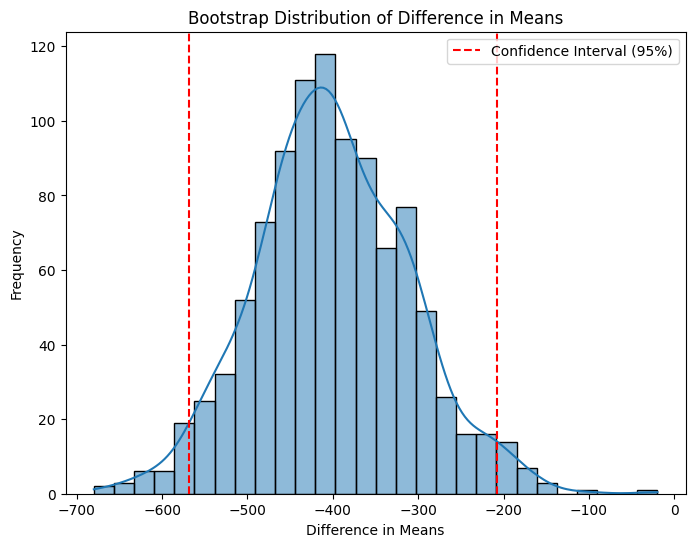

{'ci': array([-568.40879379, -208.13907551]),
 'p_value': 1.1008125851450672e-05}

In [26]:
bootstrap_results = get_bootstrap(full_data.loc[full_data.paid == 1])
bootstrap_results

По бутстрепу:\
Нулеввая разница не входит в 95% доверительный интервал.\
распределения смещены.
По тесту Студента:\
P-value позволяет отклонить H0, изменения есть!

Влияние изменений неоднозначно. ARPPU значимо выросло, остальные метрики не показывают значимых изменений. Лучшим вариантом будет продолжить наблюдения, для этого подготовим функции в задании 3 )).

## Здание 2. SQL

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas:

| Название атрибута | Тип атрибута | Смысловое значение    |
|-------------------|--------------|-----------------------|
| st_id	            | int          |	ID ученика         |
| timest 	        |timestamp     | Время решения карточки|
| correct           |	bool       |Правильно ли решена горошина?|
| subject           |	text       |Дисциплина, в которой находится горошина|


Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [27]:
!pip install -q pandahouse

In [28]:
import pandahouse as ph

In [29]:
connection_to_def = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student',
                      'password':'dpo_python_2020'
                     }

In [30]:
query = '''
SELECT COUNT(DISTINCT st_id) AS count_of_diligent_students
FROM (
    SELECT st_id
    FROM default.peas
    INNER JOIN (
        SELECT toYear(max(timest)) AS max_year, toMonth(max(timest)) AS max_month
        FROM default.peas
    ) AS max_t
    ON toYear(peas.timest) = max_t.max_year AND toMonth(peas.timest) = max_t.max_month
    GROUP BY st_id
    HAVING SUM(correct) >= 20
) AS subquery;
    '''

df = ph.read_clickhouse(query=query, connection=connection_to_def)
df

,count_of_diligent_students
0,136


2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

|Название атрибута|	Тип атрибута|	Смысловое значение|
|-----------------|-------------|---------------------|
|st_id            |	int         |	 ID ученика       |
|test_grp         |	text        |	 Метка ученика в данном эксперименте|

и default.final_project_check:

|Название атрибута|	Тип атрибута|	Смысловое значение|
|-----------------|-------------|---------------------|
|sale_time        |	timestamp   |	Время покупки     |
|money            |	int         |	Цена, по которой приобрели данный курс|
|subject          |	text 	|                         |
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU
- ARPAU
- CR в покупку
- СR активного пользователя в покупку
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [31]:
query = '''
SELECT
    group,
    COUNT(id) AS count_all_students,
    ROUND(SUM(pay) / COUNT(id),2) AS ARPU,
    ROUND(sumIf(pay, cor > 10 OR cor_math>1) / countIf(cor > 10 OR cor_math>1),2) AS ARPAU,
    ROUND(COUNT(id) / countIf(pay > 0),2) AS CR,
    ROUND(countIf(cor > 10) / countIf(pay > 0 AND cor > 10),2) AS CR_active,
    ROUND(countIf(cor_math > 1) / countIf(pay > 0 AND cor_math > 1),2) AS CR_active_math
FROM
    (SELECT
        studs.st_id AS id,
        studs.test_grp AS group,
        all_sel_tab.all_sel AS pay,
        peas_m.count_correct AS cor,
        peas_m.count_math AS cor_math
    FROM
        default.studs
    LEFT JOIN
        (
        SELECT
            st_id,
            SUM(money) AS all_sel
        FROM
            default.final_project_check
        GROUP BY
            default.final_project_check.st_id
        ) AS all_sel_tab
    ON
        studs.st_id = all_sel_tab.st_id
    LEFT JOIN
        (
        SELECT
            st_id,
            COUNT(correct) AS count_correct,
            countIf(correct = 1 and subject = 'Math') AS count_math
        FROM
            default.peas
        GROUP BY
            st_id
        ) AS peas_m
    ON
        studs.st_id = peas_m.st_id)
GROUP BY group
'''

df = ph.read_clickhouse(query=query, connection=connection_to_def)
df

,group,count_all_students,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,305,4540.98,8993.51,20.33,10.07,9.8
1,pilot,295,11508.47,23548.39,9.22,4.65,7.0


## Задание 3. Python

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Создадаим начальную таблицу только из файлов groups.csv, active_studs.csv и checks.csv

In [32]:
data = groups.merge(active_studs, how = 'left', on = 'id')
data = data.merge(checks, how = 'left', on = 'id')
data.fillna(0, inplace = True)

In [33]:
def renew_metrix(data = data, path = './data/group_add.csv'):
    '''
    Функция принимает на вход таблицу по которой производился расчёт,
    добавляет в неё новые данные по указанному пути,
    расчитывает метрики с учётом новых данных
    и возвращает новую таблицу с данными и таблицы метрик по группам.
    '''
    group_add = pd.read_csv(path)

    group_add.rename(columns = {group_add.columns[0]:'id', group_add.columns[1]:'grp'},
                                    inplace = True)
    group_add['added'] = data.added.max() + 1
    group_add = group_add.merge(active_studs, how = 'left', on = 'id')
    group_add = group_add.merge(checks, how = 'left', on = 'id')
    group_add.fillna(0, inplace = True)

    full_data = pd.concat([data, group_add])
    # Уберём атоматические оплаты.
    paid_no_active = full_data.loc[(full_data.active == 0) & (full_data.paid == 1)]
    full_data.drop(paid_no_active.loc[paid_no_active.grp == 'B'].index, axis = 0, inplace = True)
    # Конверсия
    cr = full_data.loc[full_data.active == 1] \
        .groupby('grp', as_index=False) \
        .agg({'active':'count'})

    cr['paid'] = full_data.loc[full_data.paid == 1] \
                        .groupby('grp').agg({'active':'count'}) \
                        .active.to_list()

    cr['cr'] = round((cr.paid / cr.active) * 100, 2)
    print('Корверсия на покупку')
    display(cr)

    # ARPU
    arpu = full_data.loc[full_data.active == 1] \
        .groupby('grp', as_index=False).agg({'id':'count', 'rev':'sum'}) \
        .rename(columns={'id':'num_active'}).round()

    arpu['arpu'] = round(arpu.rev / arpu.num_active,1)

    print('ARPU')
    display(arpu)

    # ARPPU
    arppu = full_data.loc[full_data.paid == 1] \
        .groupby('grp', as_index=False).agg({'id':'count', 'rev':'sum'}) \
        .rename(columns={'id':'num_active'}).round()

    arppu['arppu'] = round(arppu.rev / arppu.num_active,1)

    print('ARPPU')
    display(arppu)

    return full_data, cr, arpu, arppu

full_data, cr, arpu, arppu = renew_metrix()

Корверсия на покупку


,grp,active,paid,cr
0,A,1537,107,6.96
1,B,6803,314,4.62


ARPU


,grp,num_active,rev,arpu
0,A,1537,72820.0,47.4
1,B,6803,394974.0,58.1


ARPPU


,grp,num_active,rev,arppu
0,A,107,92096.0,860.7
1,B,314,394974.0,1257.9


In [34]:
def metrix_plotter(cr = cr, arpu = arpu, arppu = arppu):
    ''' Функция принимает Датафреймы метрик, возвращаемые функцией renew_metrix
        и выводит диаграмы метрик по группам'''
    metix_dict = [("CR", cr), ("ARPU", arpu), ("ARPPU", arppu)]
    for key, value in metix_dict:
        sns.set(style="whitegrid")
        plt.title(f'Metrics {key}')
        sns.barplot( x=value.grp, y= value[f'{key.lower()}'])
        print(value[['grp',f'{key.lower()}']])
        plt.show()


  grp    cr
0   A  6.96
1   B  4.62


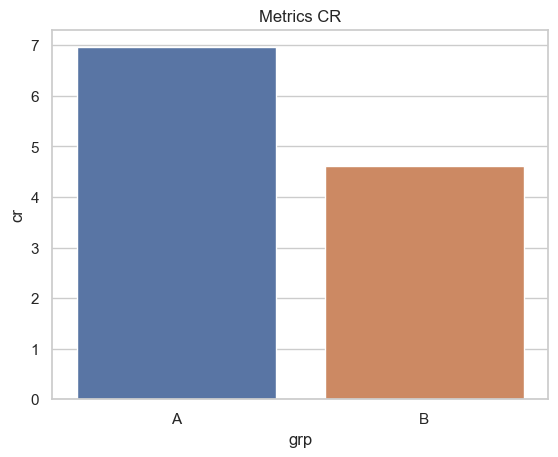

  grp  arpu
0   A  47.4
1   B  58.1


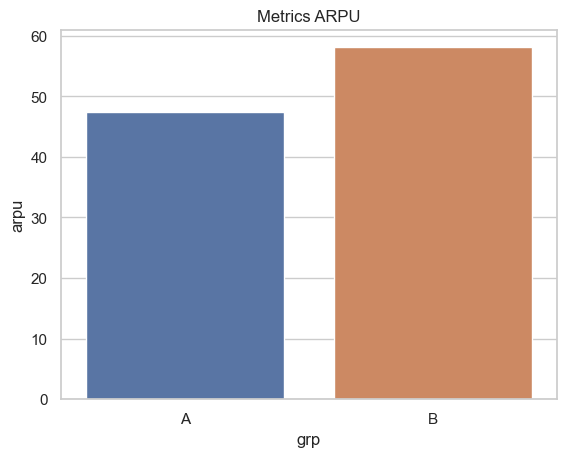

  grp   arppu
0   A   860.7
1   B  1257.9


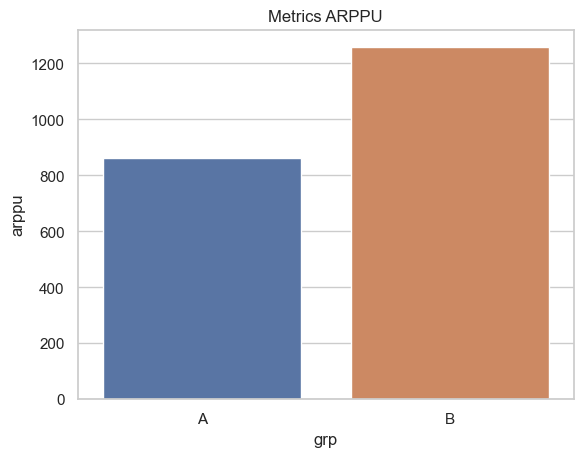

In [35]:
metrix_plotter(cr = cr, arpu = arpu, arppu = arppu)

Функции готовы! Можно продолжать наблюдения за группами.